In [1]:
import os
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.svm import SVR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np
import joblib

In [5]:
PARQUET_FILE = "gold_prices.parquet"
# Function to load data from Parquet file
def load_from_parquet():
    return pd.read_parquet(PARQUET_FILE)

# Load data
data = load_from_parquet()
print(data.columns)

Index(['('Date', '')', '('Close', 'GC=F')', '('High', 'GC=F')',
       '('Low', 'GC=F')', '('Open', 'GC=F')', '('Volume', 'GC=F')'],
      dtype='object')


In [6]:

# Rename columns for easier access
data.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

In [7]:

# Prepare data for modeling
X = np.array(range(len(data))).reshape(-1, 1)
y = data['Close'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "XGBoost": XGBRegressor(),
    "SVM": SVR(),
    "ARIMA": None,
    "Exponential Smoothing": None
}

# Train and predict with XGBoost and SVM
for name, model in models.items():
    if name in ["XGBoost", "SVM"]:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        models[name] = predictions


In [ ]:
# Train and predict with ARIMA
models["ARIMA"] = ARIMA(y_train, order=(5, 1, 0)).fit()
predictions_arima = models["ARIMA"].forecast(steps=len(y_test))
models["ARIMA"] = predictions_arima

# Train and predict with Exponential Smoothing
models["Exponential Smoothing"] = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=12).fit()
predictions_exp_smooth = models["Exponential Smoothing"].forecast(steps=len(y_test))
models["Exponential Smoothing"] = predictions_exp_smooth

# Train and predict with Prophet
from prophet import Prophet
prophet_model = Prophet()
prophet_model.add_seasonality(name='daily', period=7, fourier_order=15)
prophet_train = pd.DataFrame({'ds': pd.date_range(start='2020-01-01', periods=len(y_train)), 'y': y_train})
prophet_model.fit(prophet_train)
future = prophet_model.make_future_dataframe(periods=len(y_test))
prophet_forecast = prophet_model.predict(future)
models["Prophet"] = prophet_forecast['yhat'].iloc[-len(y_test):].values

# Train and predict with LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(1, 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(y_train.reshape(-1, 1, 1), y_train, epochs=100, verbose=0)
lstm_predictions = lstm_model.predict(y_test.reshape(-1, 1, 1))
models["LSTM"] = lstm_predictions.flatten()

# Train and predict with GRU
from keras.models import Sequential
from keras.layers import GRU, Dense
gru_model = Sequential()
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(1, 1)))
gru_model.add(GRU(units=50))
gru_model.add(Dense(1))
gru_model.compile(loss='mean_squared_error', optimizer='adam')
gru_model.fit(y_train.reshape(-1, 1, 1), y_train, epochs=100, verbose=0)
gru_predictions = gru_model.predict(y_test.reshape(-1, 1, 1))
models["GRU"] = gru_predictions.flatten()

# Train and predict with SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_model = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_results = sarima_model.fit()
sarima_predictions = sarima_results.predict(start=len(y_train), end=len(y_train)+len(y_test)-1)
models["SARIMA"] = sarima_predictions

# Train and predict with Vector Autoregression (VAR)
from statsmodels.tsa.api import VAR
var_model = VAR(y_train.reshape(-1, 1))
var_results = var_model.fit(maxlags=10)
var_predictions = var_results.forecast(y_train.reshape(-1, 1)[-10:], len(y_test))
models["VAR"] = var_predictions.flatten()

# Calculate accuracy
results = pd.DataFrame({
    "Real Price": y_test,
    "XGBoost": models["XGBoost"],
    "SVM": models["SVM"],
    "ARIMA": models["ARIMA"],
    "Exponential Smoothing": models["Exponential Smoothing"],
    "Prophet": models["Prophet"],
    "LSTM": models["LSTM"],
    "GRU": models["GRU"],
    "SARIMA": models["SARIMA"],
    "VAR": models["VAR"]
})

# Calculate Mean Squared Error (MSE)
mse_results = {
    "XGBoost": mean_squared_error(results['Real Price'], results['XGBoost']),
    "SVM": mean_squared_error(results['Real Price'], results['SVM']),
    "ARIMA": mean_squared_error(results['Real Price'], results['ARIMA']),
    "Exponential Smoothing": mean_squared_error(results['Real Price'], results['Exponential Smoothing']),
    "Prophet": mean_squared_error(results['Real Price'], results['Prophet']),
    "LSTM": mean_squared_error(results['Real Price'], results['LSTM']),
    "GRU": mean_squared_error(results['Real Price'], results['GRU']),
    "SARIMA": mean_squared_error(results['Real Price'], results['SARIMA']),
    "VAR": mean_squared_error(results['Real Price'], results['VAR'])
}

/media/mh/8484EC0884EBFA96/projects/python/gold_forecast/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


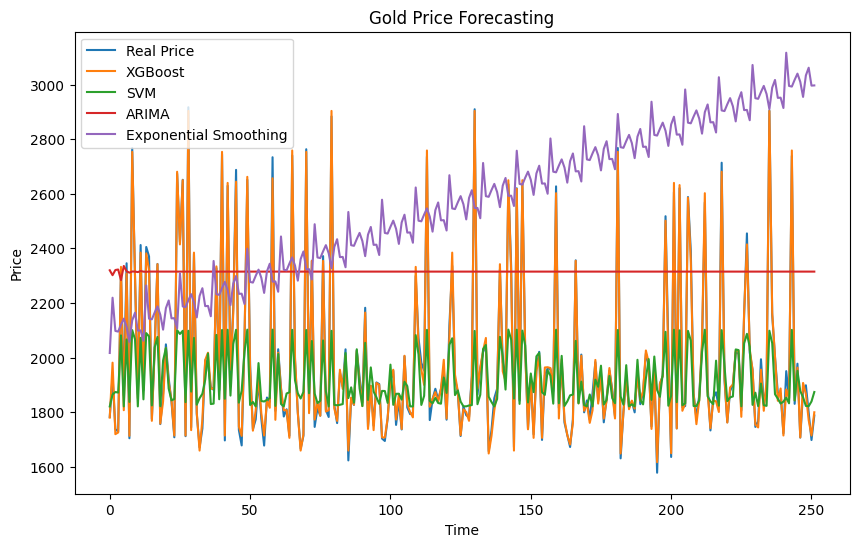

In [10]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(results['Real Price'], label='Real Price')
plt.plot(results['XGBoost'], label='XGBoost')
plt.plot(results['SVM'], label='SVM')
plt.plot(results['ARIMA'], label='ARIMA')
plt.plot(results['Exponential Smoothing'], label='Exponential Smoothing')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Gold Price Forecasting')
plt.show()

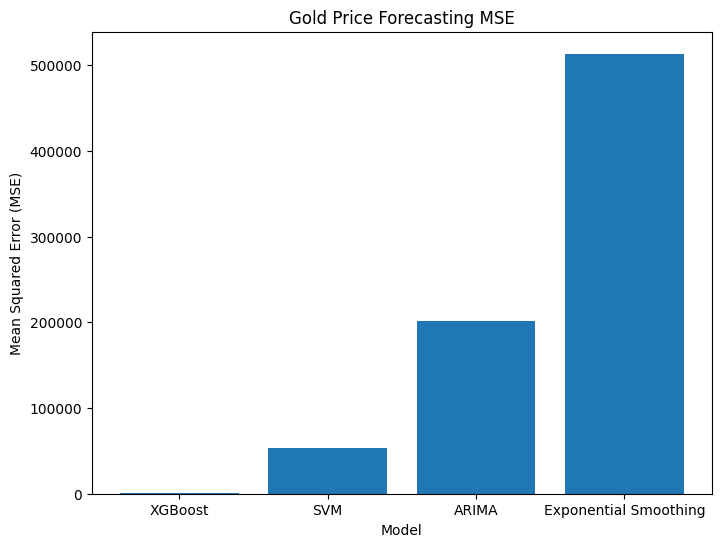

In [11]:
# Plot the MSE results
plt.figure(figsize=(8,6))
plt.bar(mse_results.keys(), mse_results.values())
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Gold Price Forecasting MSE')
plt.show()

In [14]:
from tabulate import tabulate

# Create a list of lists to store the results
results_table = []

# Get the test dates
test_dates = data['Date'].iloc[-len(y_test):].tolist()

# Create a dictionary to store the results
results_dict = {
    "Test Date": test_dates,
    "Real Price": y_test.tolist(),
    "XGBoost": models["XGBoost"].tolist(),
    "SVM": models["SVM"].tolist(),
    "ARIMA": models["ARIMA"].tolist(),
    "Exponential Smoothing": models["Exponential Smoothing"].tolist()
}

# Calculate the difference and accuracy for each model
for model_name in ["XGBoost", "SVM", "ARIMA", "Exponential Smoothing"]:
    results_dict[f"{model_name} Difference"] = [abs(a - b) for a, b in zip(y_test, models[model_name])]
    results_dict[f"{model_name} Accuracy"] = [(1 - abs(a - b) / a) * 100 for a, b in zip(y_test, models[model_name])]

# Print the results as a table
print(tabulate(results_dict, headers="keys", tablefmt="grid"))

+---------------------+--------------+-----------+---------+---------+-------------------------+----------------------+--------------------+------------------+----------------+--------------------+------------------+------------------------------------+----------------------------------+
| Test Date           |   Real Price |   XGBoost |     SVM |   ARIMA |   Exponential Smoothing |   XGBoost Difference |   XGBoost Accuracy |   SVM Difference |   SVM Accuracy |   ARIMA Difference |   ARIMA Accuracy |   Exponential Smoothing Difference |   Exponential Smoothing Accuracy |
+=====================+==============+===========+=========+=========+=========================+======================+====================+==================+================+====================+==================+====================================+==================================+
| 2024-03-15 00:00:00 |       1782.6 |   1780.02 | 1821.01 | 2319.71 |                 2016.79 |            2.578     |            99

In [15]:
from tabulate import tabulate

# Create a dictionary to store the summary results
summary_results = {
    "Model": ["XGBoost", "SVM", "ARIMA", "Exponential Smoothing"],
    "MSE": [mean_squared_error(y_test, models["XGBoost"]), 
            mean_squared_error(y_test, models["SVM"]), 
            mean_squared_error(y_test, models["ARIMA"]), 
            mean_squared_error(y_test, models["Exponential Smoothing"])],
    "MAE": [np.mean([abs(a - b) for a, b in zip(y_test, models["XGBoost"])]), 
            np.mean([abs(a - b) for a, b in zip(y_test, models["SVM"])]), 
            np.mean([abs(a - b) for a, b in zip(y_test, models["ARIMA"])]), 
            np.mean([abs(a - b) for a, b in zip(y_test, models["Exponential Smoothing"])])],
    "RMSE": [np.sqrt(mean_squared_error(y_test, models["XGBoost"])), 
             np.sqrt(mean_squared_error(y_test, models["SVM"])), 
             np.sqrt(mean_squared_error(y_test, models["ARIMA"])), 
             np.sqrt(mean_squared_error(y_test, models["Exponential Smoothing"]))],
    "Accuracy": [np.mean([(1 - abs(a - b) / a) * 100 for a, b in zip(y_test, models["XGBoost"])]), 
                 np.mean([(1 - abs(a - b) / a) * 100 for a, b in zip(y_test, models["SVM"])]), 
                 np.mean([(1 - abs(a - b) / a) * 100 for a, b in zip(y_test, models["ARIMA"])]), 
                 np.mean([(1 - abs(a - b) / a) * 100 for a, b in zip(y_test, models["Exponential Smoothing"])])]
}

# Print the summary results as a table
print(tabulate(summary_results, headers="keys", tablefmt="grid"))

+-----------------------+------------+---------+----------+------------+
| Model                 |        MSE |     MAE |     RMSE |   Accuracy |
+=======================+============+=========+==========+============+
| XGBoost               |    412.857 |  15.108 |  20.3189 |    99.237  |
+-----------------------+------------+---------+----------+------------+
| SVM                   |  53108.9   | 142.545 | 230.454  |    93.5905 |
+-----------------------+------------+---------+----------+------------+
| ARIMA                 | 201028     | 421.089 | 448.361  |    77.687  |
+-----------------------+------------+---------+----------+------------+
| Exponential Smoothing | 513492     | 642.127 | 716.584  |    65.8061 |
+-----------------------+------------+---------+----------+------------+
